## 다변수 선형회귀: 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?
### 시간, 온도, 습도, 계절 등의 정보가 담긴 데이터를 통해 자전거의 대여량을 예측하는 문제
### 자전거 대여량을 결정하는 데에는 시간도 중요할 것이고, 요일이나 계절도 크게 영향을 미칠 것 같다
### 직접 손실함수와 기울기를 계산하지 않고, 사이킷런(sklearn)의 LinearRegression 모델을 활용할 것

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## (1) 데이터 가져오기

In [3]:
# 데이터 불러오기
# train.csv 불러오기

train = pd.read_csv('./bike_sharing_data/train.csv')
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [4]:
# 데이터 shape 확인하기
print(train.shape)

(10886, 12)


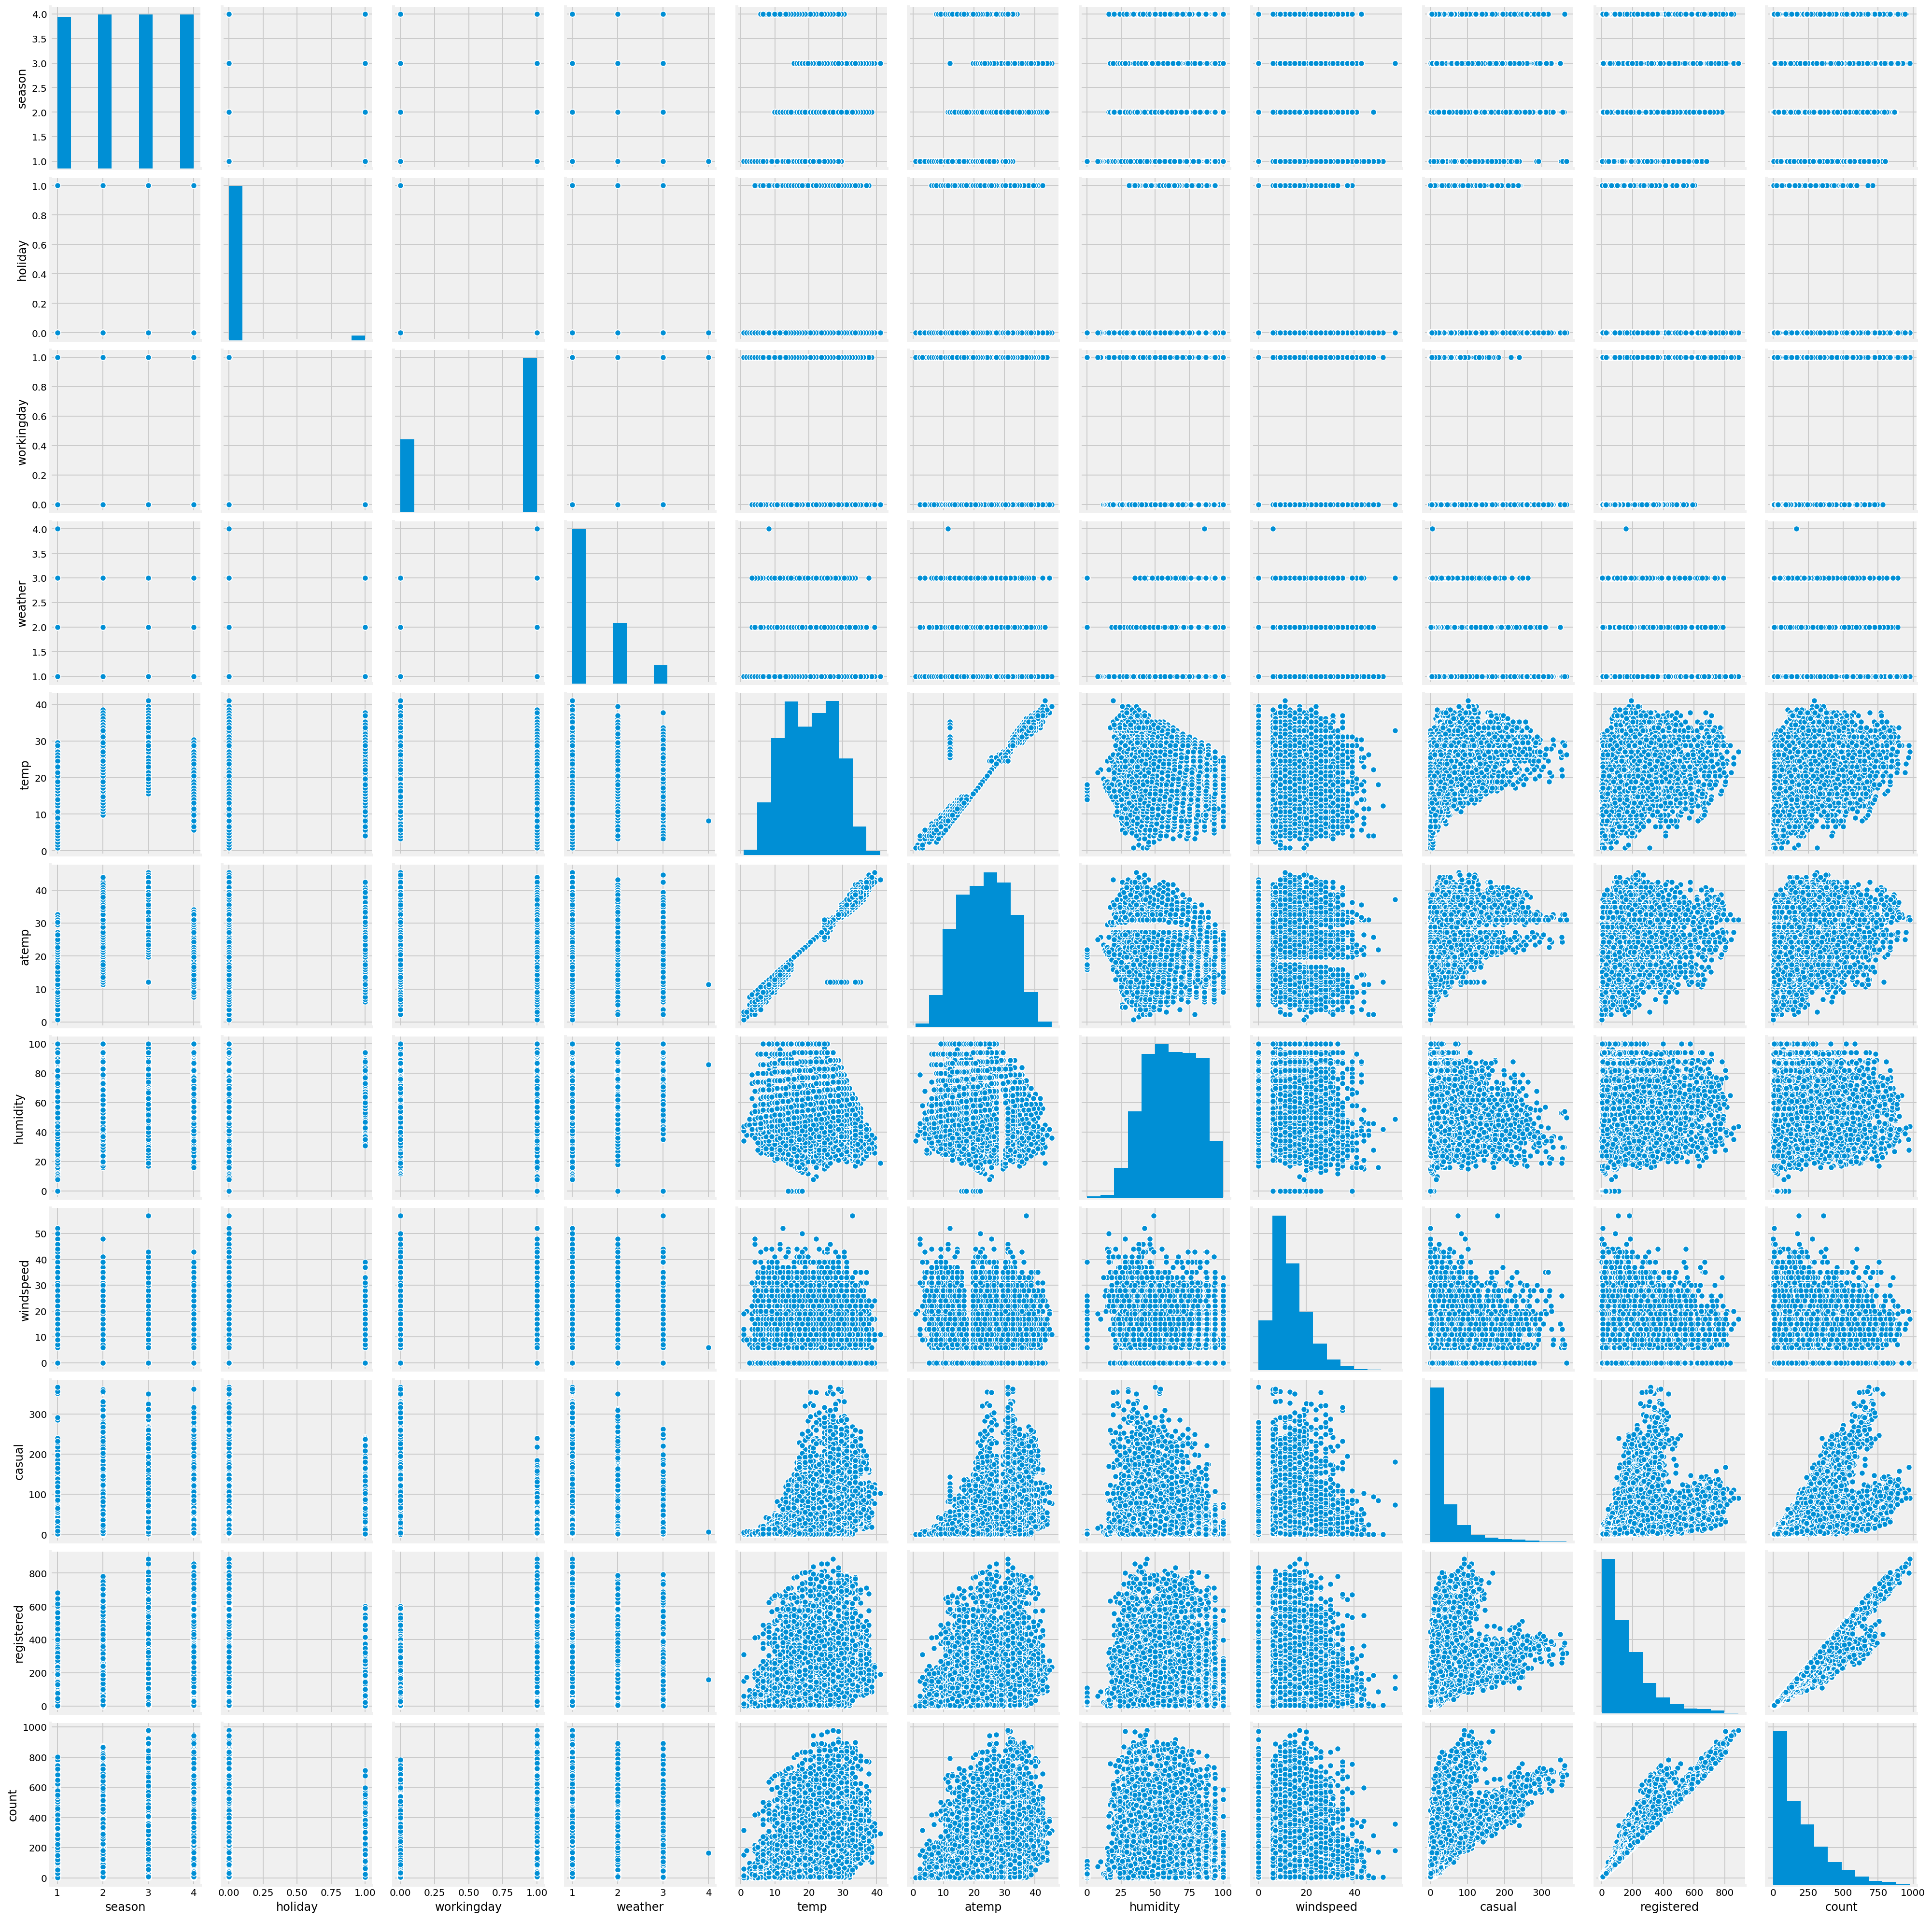

In [5]:
# sns.pairplot() : 데이터 분포 시각화
sns.pairplot(train)

## (2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [6]:
# datetime 컬럼을 datetime자료형으로 변환
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [7]:
# 6가지 컬럼 생성하기

train['year'] = train['datetime'].map(lambda x : x.year)
train['month'] = train['datetime'].map(lambda x : x.month)
train['day'] = train['datetime'].map(lambda x : x.day)
train['hour'] = train['datetime'].map(lambda x : x.hour)
train['minute'] = train['datetime'].map(lambda x : x.minute)
train['second'] = train['datetime'].map(lambda x : x.second)

train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81        0.0       3          13     16  2011      1    1     0   
1        80        0.0       8          32     40  2011      1    1     1   
2        80        0.0       5          27     32  2011      1    1     2   
3        75        0.0       3          10     13  2011      1    1     3   
4        75        0.0       0           1      1  2011      1    1     4   

   minute  second  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0

## (3) year, month, day, hour, minute, second 데이터 개수 시각화하기

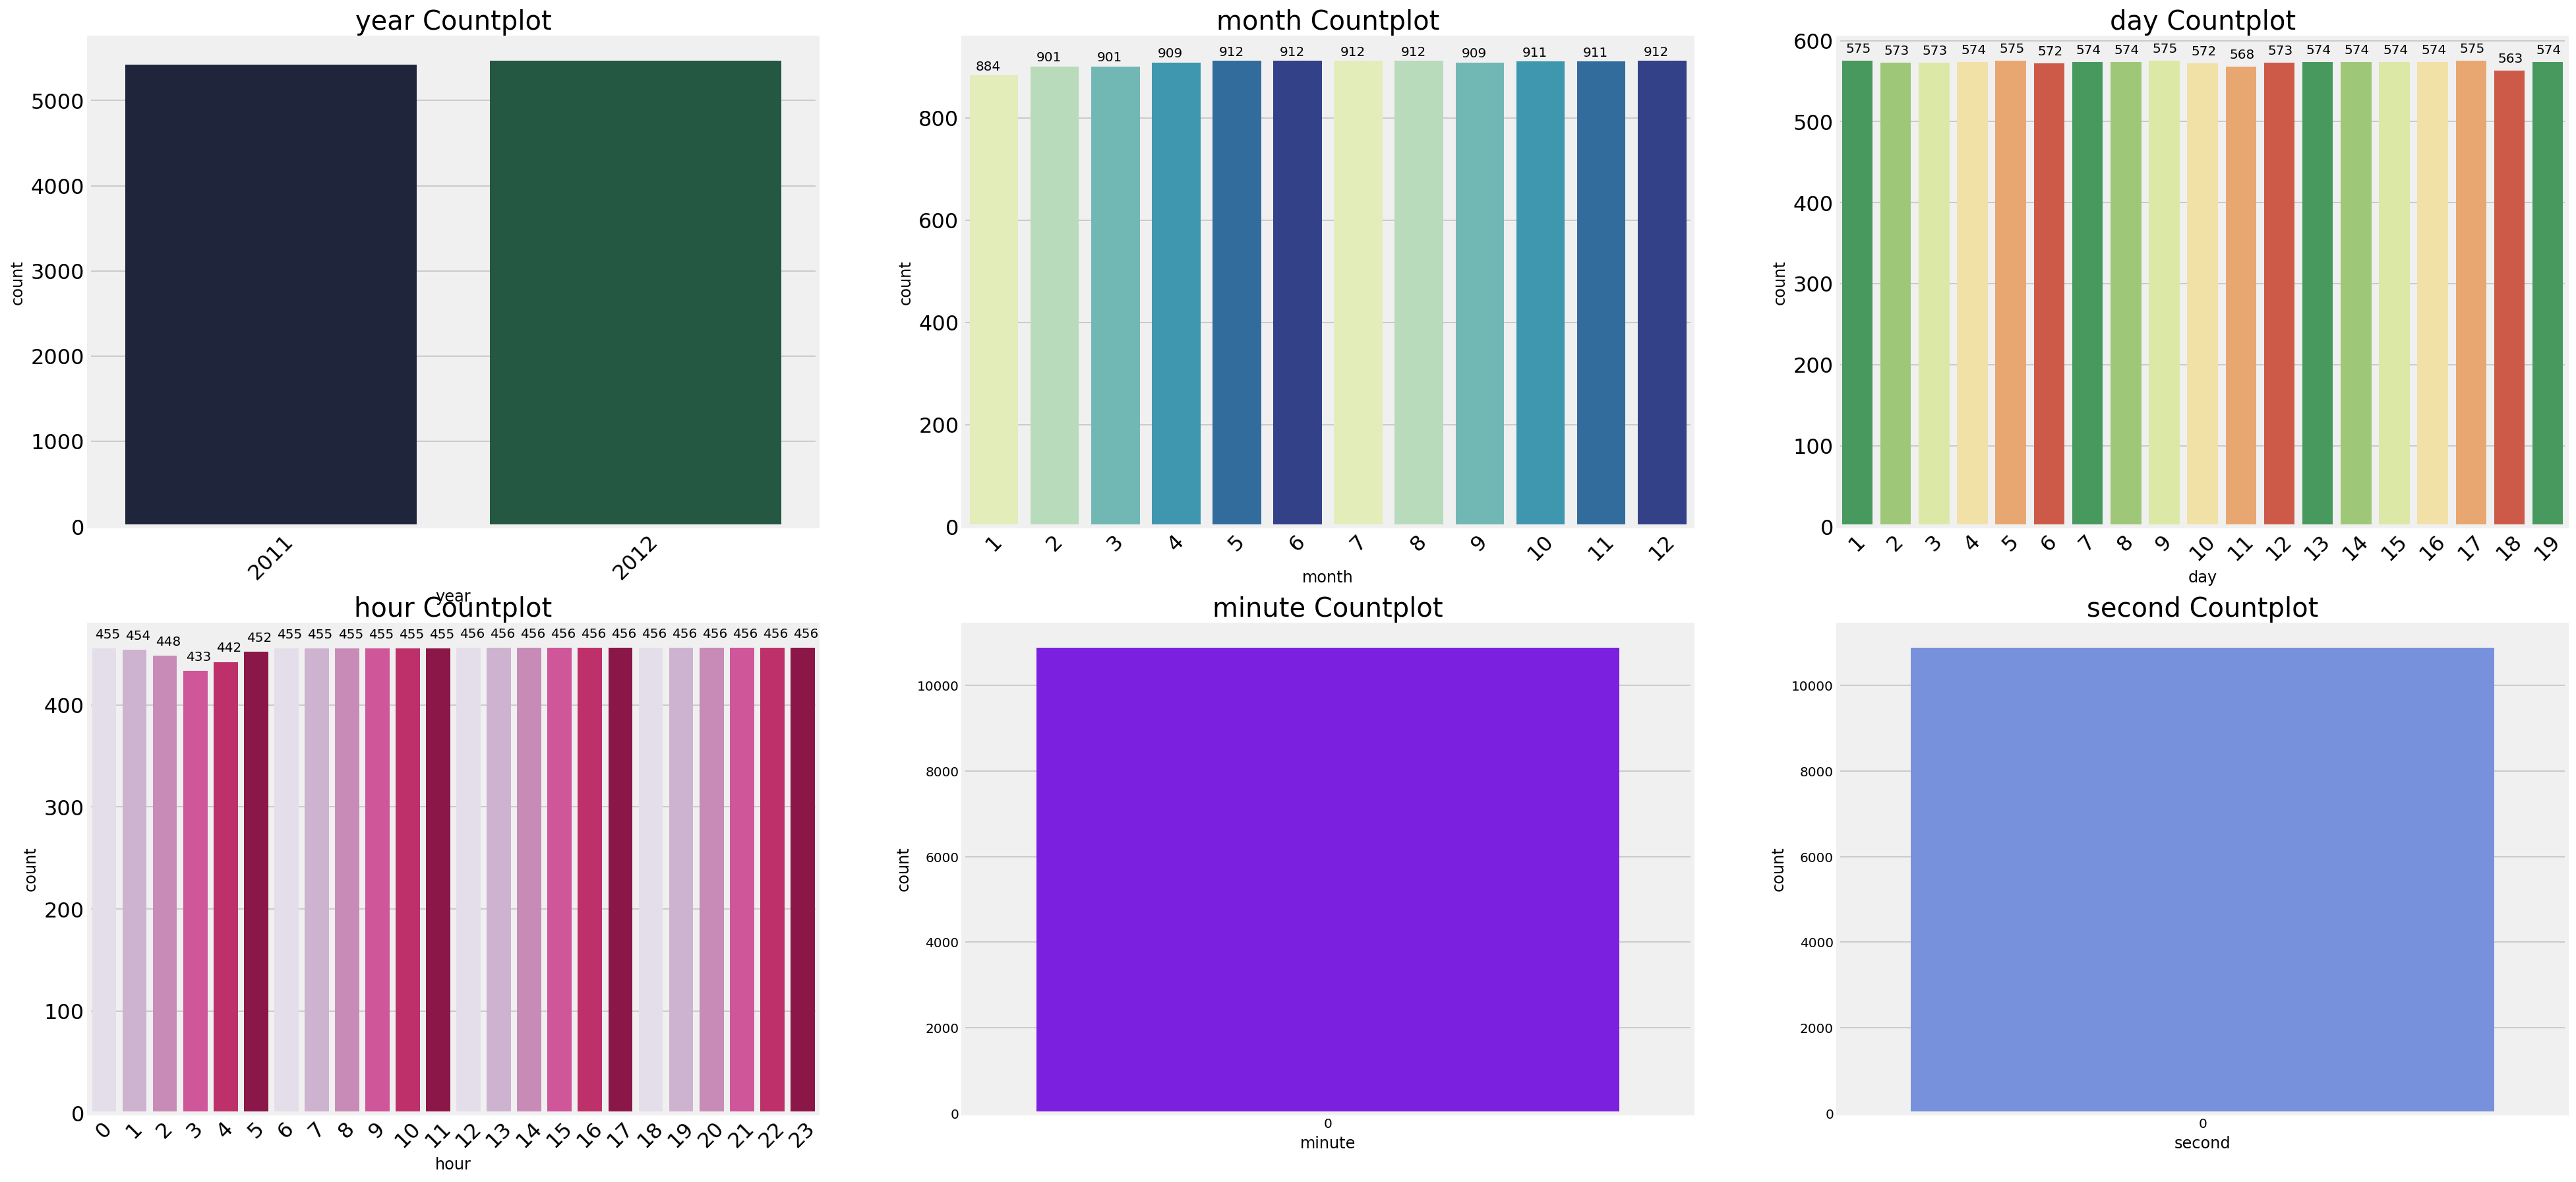

In [8]:
# sns.countplot, subplot활용
# month. day, hour은 막대 그래프 상위에 값 출력

fig = plt.figure(figsize=(30,15))
palettes = ['cubehelix','YlGnBu','RdYlGn_r' ,'PuRd','gist_rainbow_r','coolwarm']
for i, col in enumerate(['year', 'month', 'day', 'hour', 'minute','second']):
    plt.subplot(2,3,i+1)
    ax = sns.countplot(train[col], palette=sns.color_palette(palettes[i]))
    plt.title('{} Countplot'.format(col), fontsize=20)
    if i not in  [0, 4, 5]:
        for p in ax.patches:
            ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
    if i in [4,5]:
        continue
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)

## (4) X, y 컬럼 선택 및 train/test 데이터 분리
### X에는 문자열 데이터, 쓸모없는 데이터를 제외한 컬럼의 데이터 넣기
### count 값을 맞추고자 하므로, y 변수에 count 컬럼의 데이터 넣기

In [9]:
# info()를 통해서 데이터들의 type을 확인 (문자열 데이터 확인)
# train['datetime'].dt.weekday 활용, 요일에 대한 정보 추가

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  minute      10886 non-

In [10]:
# 요일 정보
train['datetime'].dt.weekday

0        5
1        5
2        5
3        5
4        5
        ..
10881    2
10882    2
10883    2
10884    2
10885    2
Name: datetime, Length: 10886, dtype: int64

In [11]:
# 요일 시간 날씨
day = train['datetime'].dt.weekday
X = pd.concat([train['hour'], train['weather'], train['datetime'].dt.weekday], axis=1, ignore_index=False)
y = train['count']

X

hour  weather  datetime
0         0        1         5
1         1        1         5
2         2        1         5
3         3        1         5
4         4        1         5
...     ...      ...       ...
10881    19        1         2
10882    20        1         2
10883    21        1         2
10884    22        1         2
10885    23        1         2

[10886 rows x 3 columns]

## (5) LinearRegression 모델 학습
### sklearn의 LinearRegression 모델 불러오기 및 학습하기

In [12]:
def model_train(X, y) :
    
    global X_train, X_test, y_train, y_test, y_pred 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=94)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    
    return score, np.sqrt(score)

## (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산
#### 학습된 모델에 X_test를 입력해서 예측값 출력하기
#### 모델이 예측한 값과 정답 target 간의 손실함수 값 계산하기
#### mse 값과 함께 rmse 값도 계산하기

In [13]:
mse_score, rmse_score = model_train(X, y)
print("MSE : {:.4f}\nRMSE : {:.4f}".format(mse_score, rmse_score))

MSE : 27899.4770
RMSE : 167.0314


In [14]:
# 요일 시간 날씨 + temp
X = pd.concat([train['hour'], train['weather'], train['datetime'].dt.weekday, train['temp']], axis=1, ignore_index=False)
X

hour  weather  datetime   temp
0         0        1         5   9.84
1         1        1         5   9.02
2         2        1         5   9.02
3         3        1         5   9.84
4         4        1         5   9.84
...     ...      ...       ...    ...
10881    19        1         2  15.58
10882    20        1         2  14.76
10883    21        1         2  13.94
10884    22        1         2  13.94
10885    23        1         2  13.12

[10886 rows x 4 columns]

In [15]:
mse_score, rmse_score = model_train(X, y)
print("MSE : {:.4f}\nRMSE : {:.4f}".format(mse_score, rmse_score))

MSE : 24108.3948
RMSE : 155.2688


In [16]:
# 요일 시간 날씨 + humidity
X = pd.concat([train['hour'], train['weather'], train['datetime'].dt.weekday, train['humidity']], axis=1, ignore_index=False)
X

hour  weather  datetime  humidity
0         0        1         5        81
1         1        1         5        80
2         2        1         5        80
3         3        1         5        75
4         4        1         5        75
...     ...      ...       ...       ...
10881    19        1         2        50
10882    20        1         2        57
10883    21        1         2        61
10884    22        1         2        61
10885    23        1         2        66

[10886 rows x 4 columns]

In [17]:

mse_score, rmse_score = model_train(X, y)
print("MSE : {:.4f}\nRMSE : {:.4f}".format(mse_score, rmse_score))

MSE : 26661.2264
RMSE : 163.2827


In [18]:
# 요일 시간 날씨 + humidity + temp
X = pd.concat([train['hour'], train['weather'], train['datetime'].dt.weekday, train['humidity'], train['temp']], axis=1, ignore_index=False)
X

hour  weather  datetime  humidity   temp
0         0        1         5        81   9.84
1         1        1         5        80   9.02
2         2        1         5        80   9.02
3         3        1         5        75   9.84
4         4        1         5        75   9.84
...     ...      ...       ...       ...    ...
10881    19        1         2        50  15.58
10882    20        1         2        57  14.76
10883    21        1         2        61  13.94
10884    22        1         2        61  13.94
10885    23        1         2        66  13.12

[10886 rows x 5 columns]

In [19]:
mse_score, rmse_score = model_train(X, y)
print("MSE : {:.4f}\nRMSE : {:.4f}".format(mse_score, rmse_score))

MSE : 22934.6071
RMSE : 151.4418


In [20]:
# 요일 시간 날씨 + humidity + temp, atemp + season
X = pd.concat([train['hour'], train['weather'], train['datetime'].dt.weekday, train['humidity'], train['temp'], train['atemp'], train['season']], axis=1, ignore_index=False)
X

hour  weather  datetime  humidity   temp   atemp  season
0         0        1         5        81   9.84  14.395       1
1         1        1         5        80   9.02  13.635       1
2         2        1         5        80   9.02  13.635       1
3         3        1         5        75   9.84  14.395       1
4         4        1         5        75   9.84  14.395       1
...     ...      ...       ...       ...    ...     ...     ...
10881    19        1         2        50  15.58  19.695       4
10882    20        1         2        57  14.76  17.425       4
10883    21        1         2        61  13.94  15.910       4
10884    22        1         2        61  13.94  17.425       4
10885    23        1         2        66  13.12  16.665       4

[10886 rows x 7 columns]

In [21]:
mse_score, rmse_score = model_train(X, y)
print("MSE : {:.4f}\nRMSE : {:.4f}".format(mse_score, rmse_score))

MSE : 22387.6960
RMSE : 149.6252


## RMSE 값 150 이하를 달성!

## (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

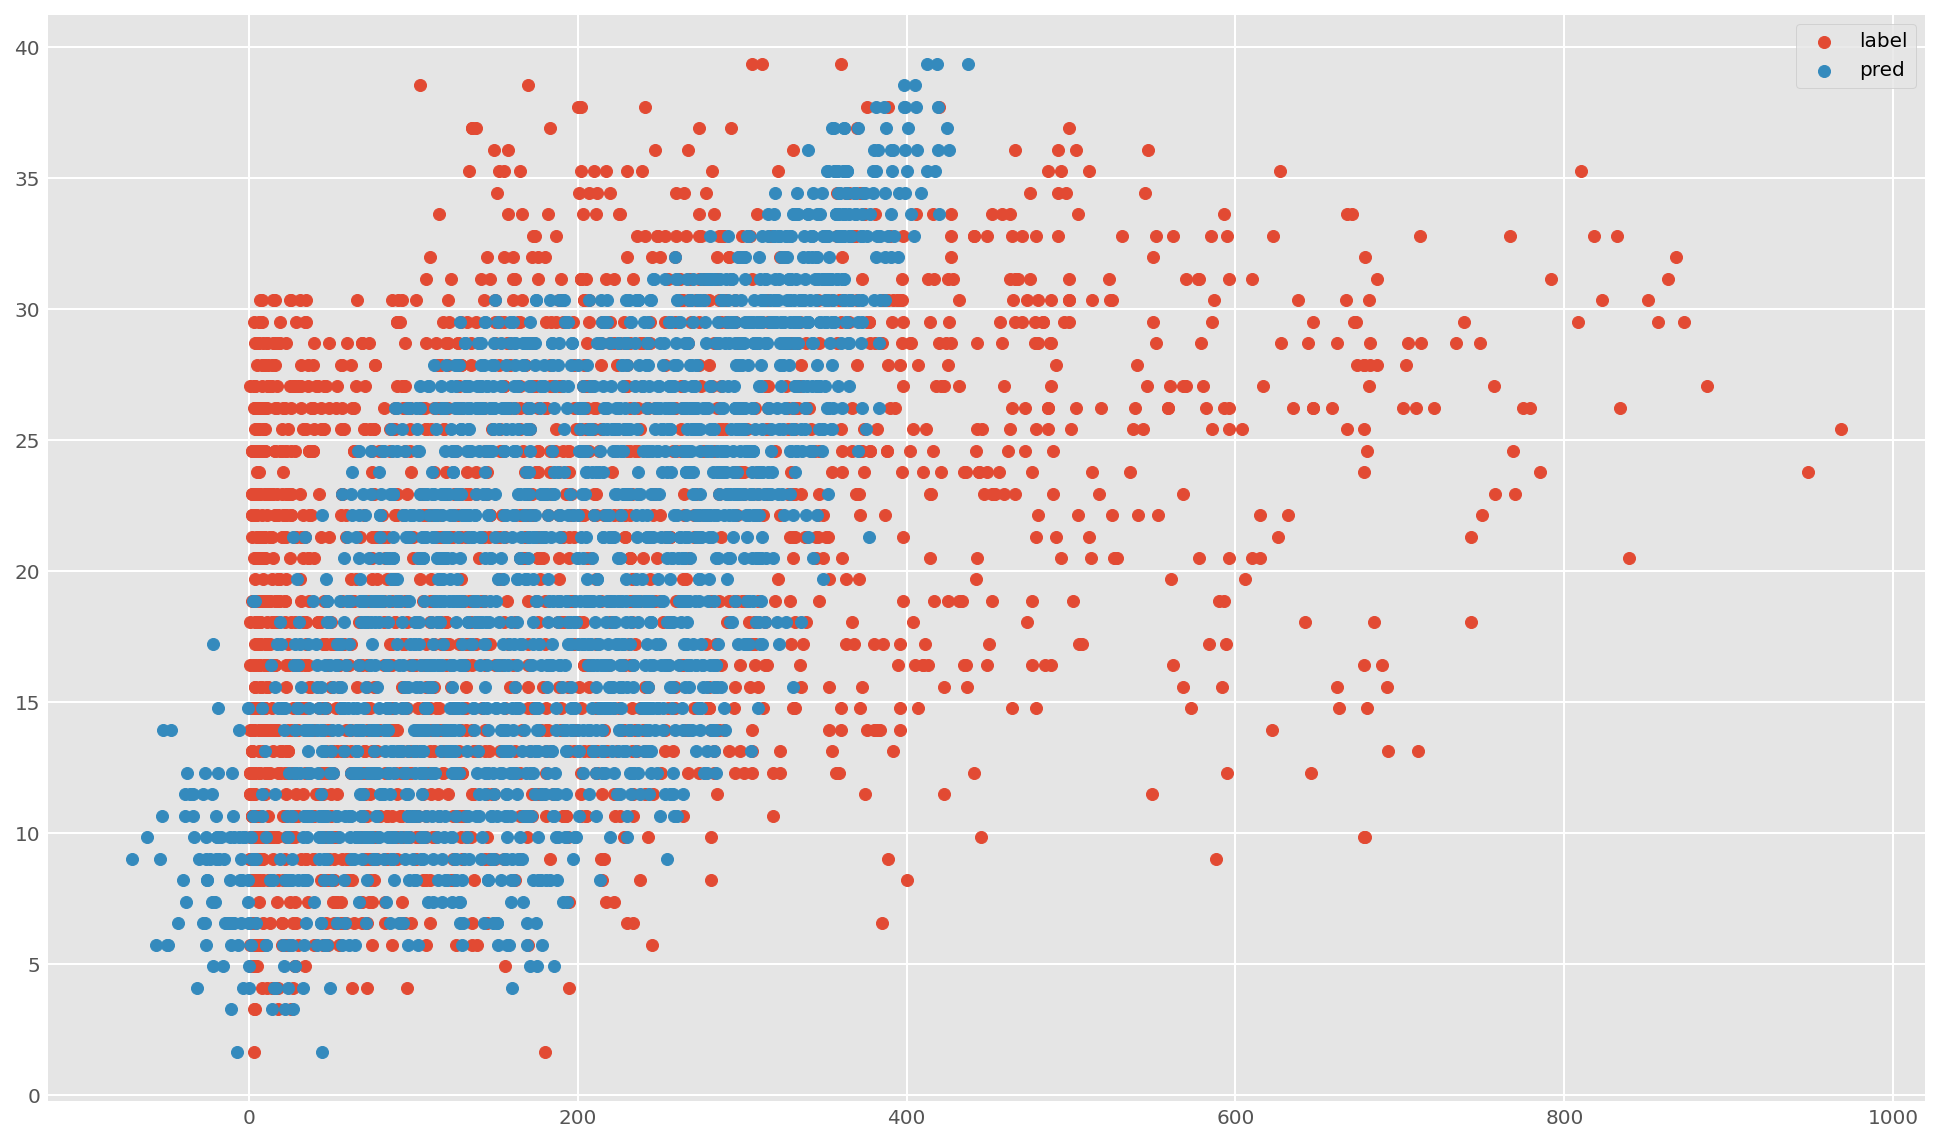

In [22]:
# x축에 X 데이터 중 temp 데이터를, y축에는 count 데이터를 넣어서 시각화하기
plt.style.use('ggplot')
plt.figure(figsize=(15, 10))
plt.scatter(y_test, X_test['temp'], label="label")
plt.scatter(y_pred, X_test['temp'], label="pred")
plt.legend()

plt.show()

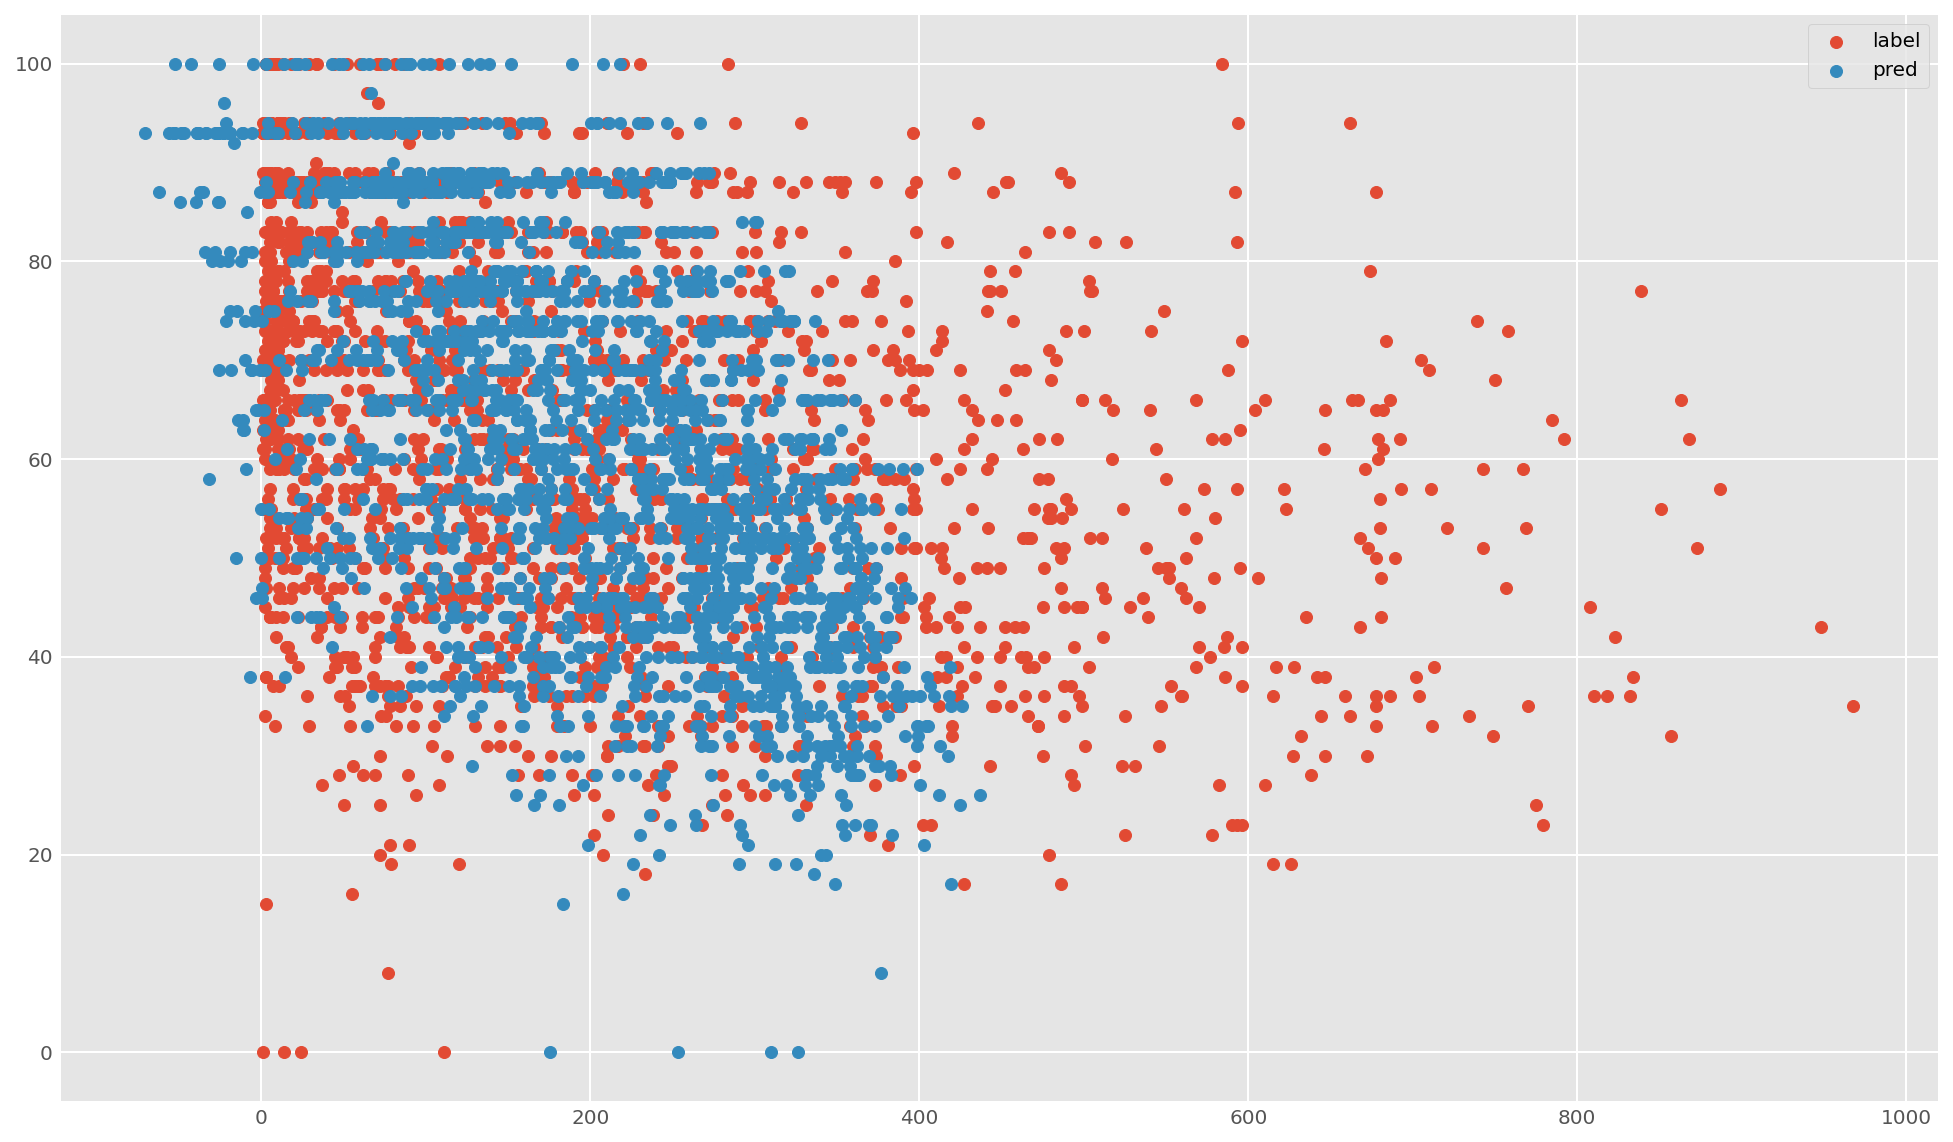

In [23]:
# x축에 X 데이터 중 humidity 데이터를, y축에는 count 데이터를 넣어서 시각화하기
plt.style.use('ggplot')
plt.figure(figsize=(15, 10))
plt.scatter(y_test, X_test['humidity'], label="label")
plt.scatter(y_pred, X_test['humidity'], label="pred")
plt.legend()

plt.show()

## 시각화를 통해서 관찰된 점
### 데이터개수 시각화 및 예측결과 시각화를 진행하였으며, 예측과 실제 데이터가 크게 분리되지 않고 비슷함